In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm

# Selection of Key Chemical Species

Objective: Verify the following points for data consistency and calculation feasibility:

* Determine if TSM (Total Suspended Matter) and SPM (Suspended Particulate Matter) are equivalent, where SPM is also referred to as STS (suspendert tørrstoff).
* Assess whether POC (Particulate Organic Carbon) can be calculated with the available data.
* Check if DOC (Dissolved Organic Carbon) can be used as a substitute for TOC (Total Organic Carbon).
* Check the relationship between sensor CDOM and UVAbs 410 or Farge from the river.
* Check if NO3 is quite higher than NH4 and if yes compute DIN. 

### 1. User input

In [2]:
df = pd.read_csv('../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_wc_flagged_2024_cleaned.csv')
df.keys()

Index(['sample_date', 'station_id', 'station_code', 'station_name',
       'DOC_mg/L C', 'outlier_DOC_mg/L C', 'Farge_mg Pt/l',
       'outlier_Farge_mg Pt/l', 'NH4-N_µg/l', 'outlier_NH4-N_µg/l',
       'NO3-N_µg/l', 'outlier_NO3-N_µg/l', 'PO4-P_µg/l', 'outlier_PO4-P_µg/l',
       'STS_mg/l', 'outlier_STS_mg/l', 'SiO2_mg/l', 'outlier_SiO2_mg/l',
       'TOC_mg/l', 'outlier_TOC_mg/l', 'TOTN_µg/l', 'outlier_TOTN_µg/l',
       'TOTP/F_µg/l P', 'outlier_TOTP/F_µg/l P', 'TOTP_P_µg/l P',
       'outlier_TOTP_P_µg/l P', 'TSM_mg/l', 'outlier_TSM_mg/l',
       'UV-Abs. 410nm_Abs/cm', 'outlier_UV-Abs. 410nm_Abs/cm'],
      dtype='object')

### 2. TSM vs STS

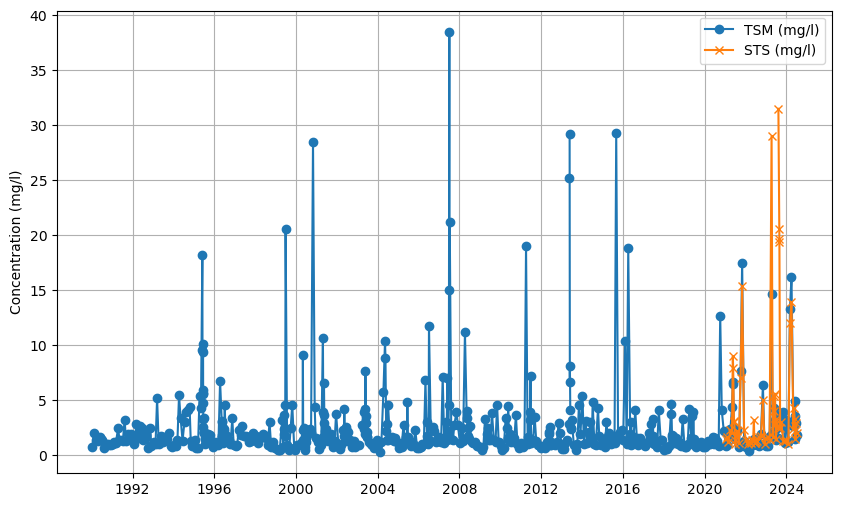

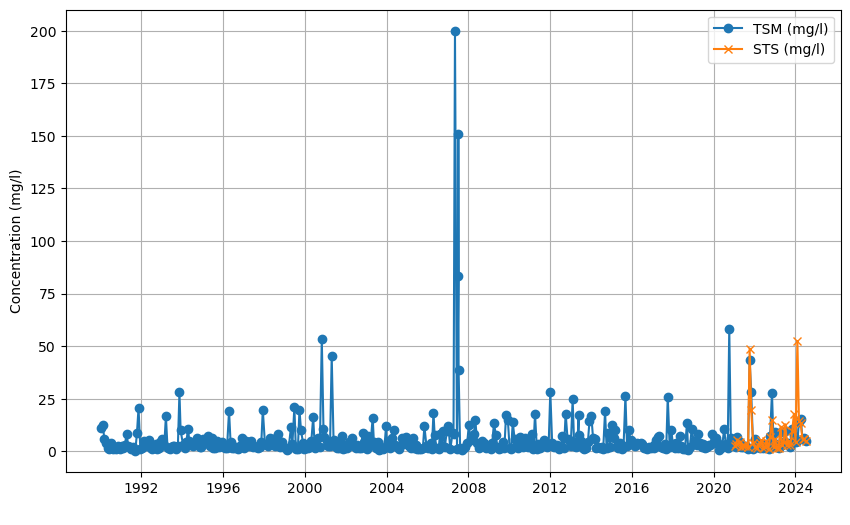

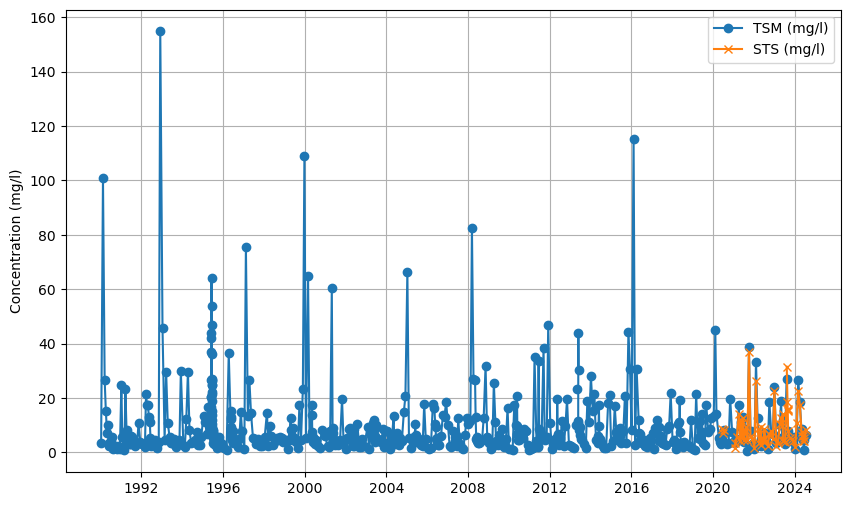

In [3]:
# Convert sample_date to datetime
df['sample_date'] = pd.to_datetime(df['sample_date'])

# Plot TSM and STS for each station separately
stations = df['station_code'].unique()

for station in stations:
    station_df = df[df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['TSM_mg/l'], label='TSM (mg/l)', marker='o')
    plt.plot(station_df['sample_date'], station_df['STS_mg/l'], label='STS (mg/l)', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Øyvind:** The main difference between the methods is that STS uses "regular" glass fiber filters: GF/C (0.45 µm), and the weighing of the filters takes place on a "regular" analytical weight that weighs grams with 4 (or maybe 5) decimal places. TSM uses nucleopore capillary filters, which have smaller pore size (0.2 µm? - not confirmed with the lab!) than the glass fiber filters. Filters are weighed on a micro-weight, which measures the weight in milligrams with several decimal places. In principle, TSM values should be higher than STS due to smaller filter pore size.

**Leah:** We can just use TSM. We have more data and TSM is moreaccurate than STS.

### 3. DOC vs TOC

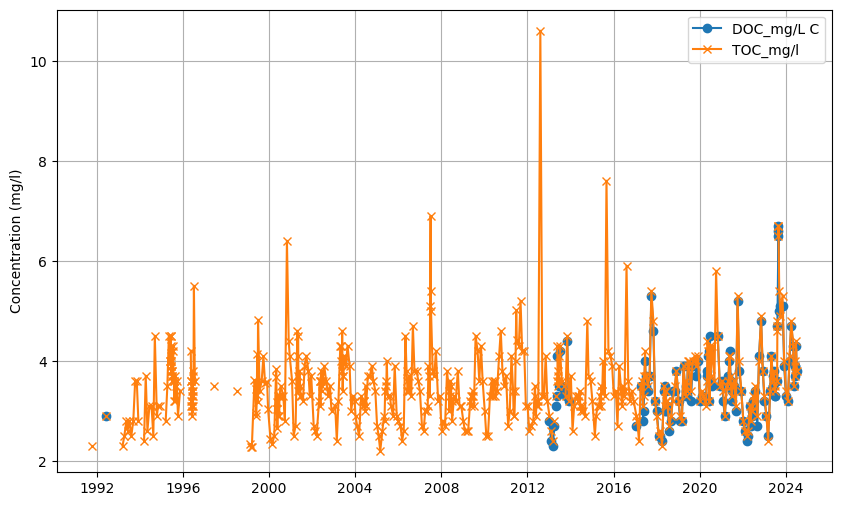

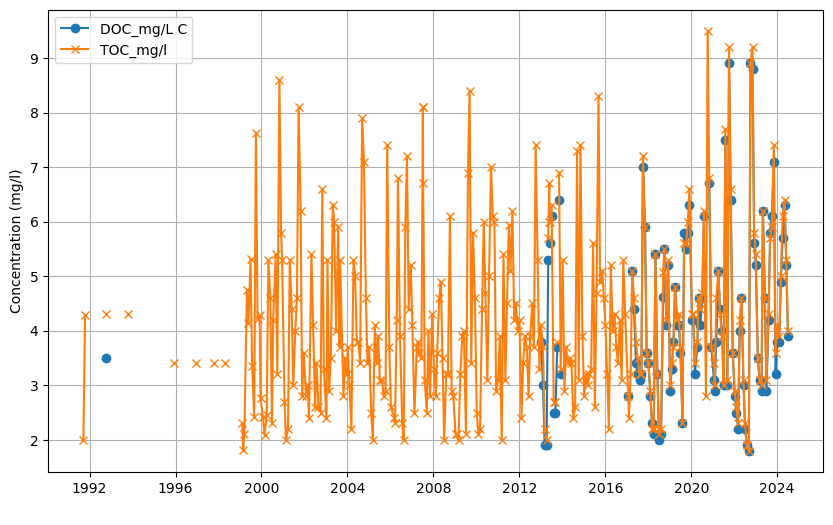

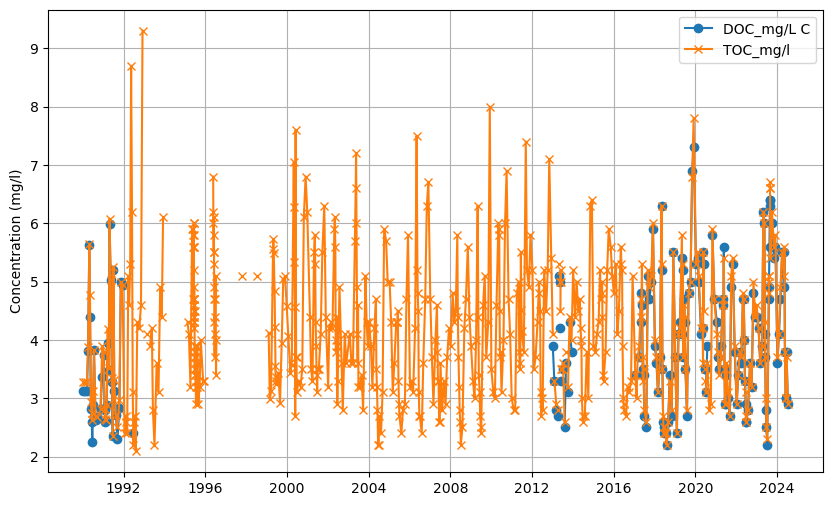

In [4]:
for station in stations:
    station_df = df[df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['DOC_mg/L C'], label='DOC_mg/L C', marker='o')
    plt.plot(station_df['sample_date'], station_df['TOC_mg/l'], label='TOC_mg/l', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Leah:** Looks like DOC basically == TOC in all rivers and that POC is really low. Could you quickly work out the average ratio between DOC and TOC and make a note of it for all 3 rivers? Then lets justify how low that is for assuming that TOC = DOC and just using TOC (given it has a longer and more continuous series).

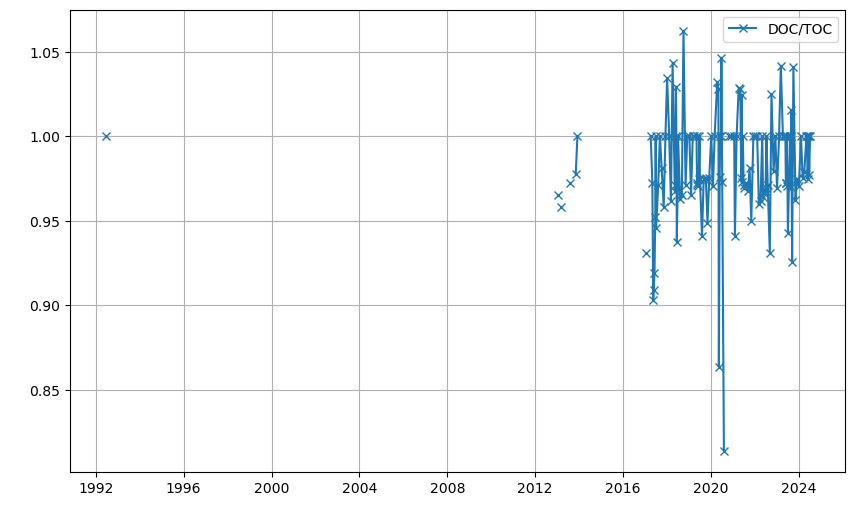

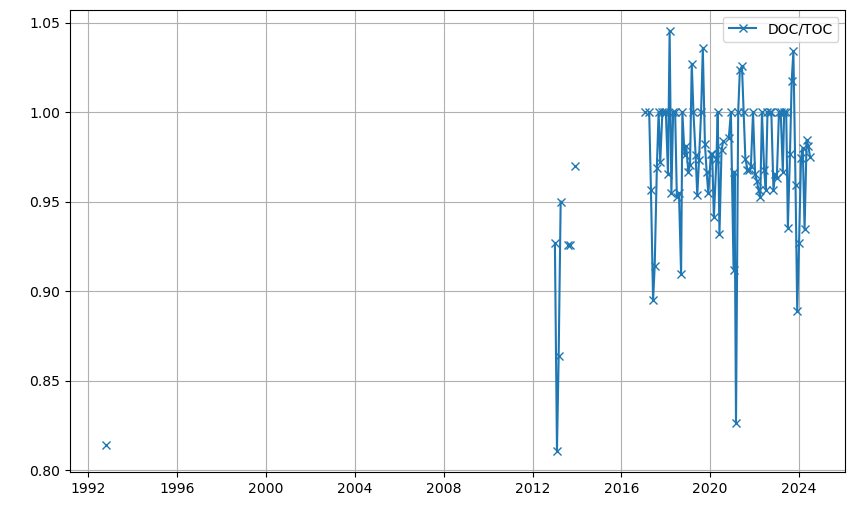

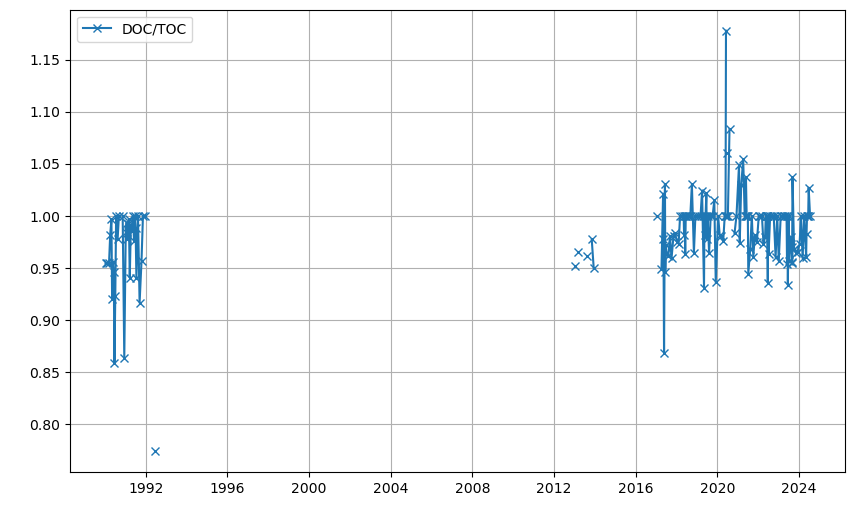

In [5]:
df['DOC/TOC'] = df['DOC_mg/L C'] / df['TOC_mg/l']

for station in stations:
    station_df = df[df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['DOC/TOC'], label='DOC/TOC', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel(' ')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
ratios = df.groupby('station_code')['DOC/TOC'].mean().reset_index()
ratios

,station_code,DOC/TOC
0,DRA1,0.981463
1,GLO1,0.983455
2,NUM1,0.968407


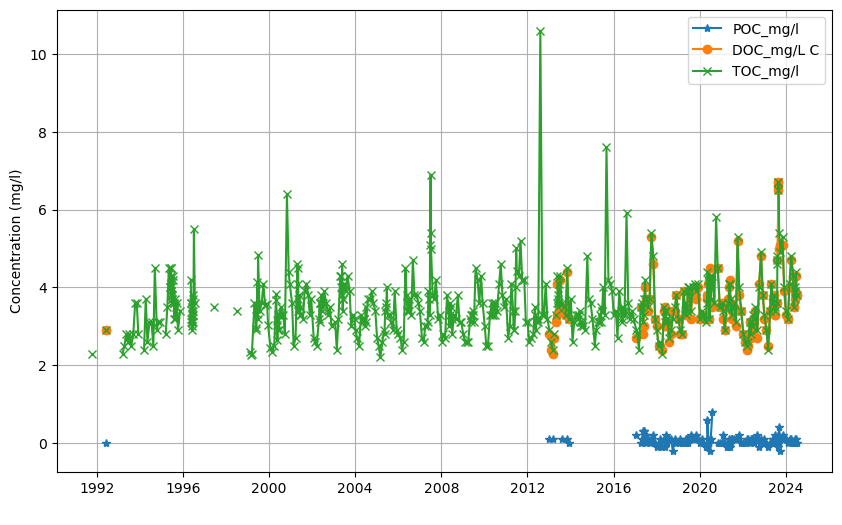

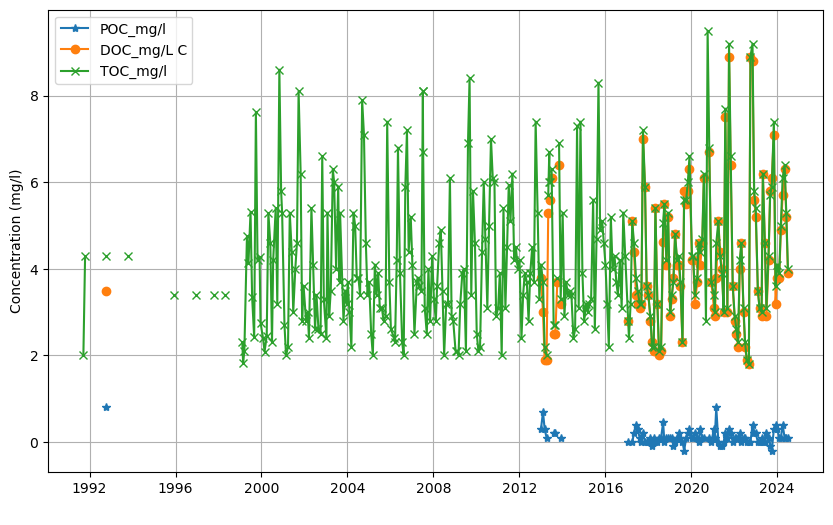

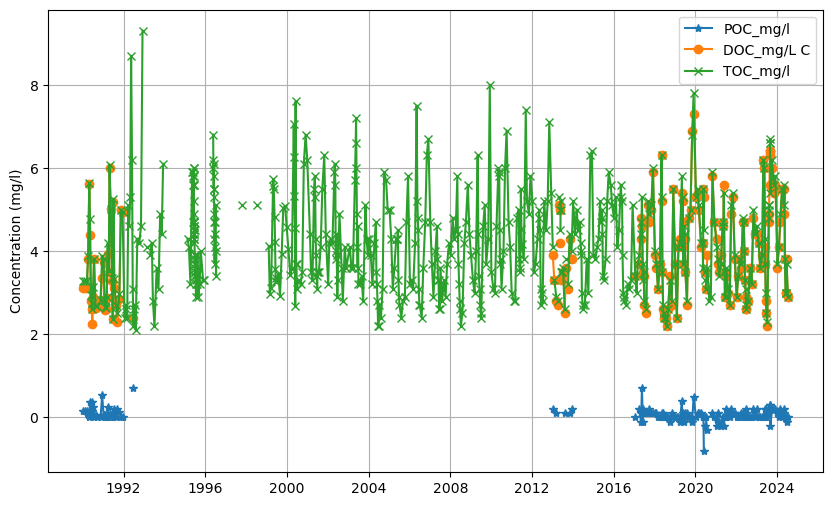

In [7]:
df['POC_mg/l'] = df['TOC_mg/l'] - df['DOC_mg/L C']

for station in stations:
    station_df = df[df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['POC_mg/l'], label='POC_mg/l', marker='*')
    plt.plot(station_df['sample_date'], station_df['DOC_mg/L C'], label='DOC_mg/L C', marker='o')
    plt.plot(station_df['sample_date'], station_df['TOC_mg/l'], label='TOC_mg/l', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Leah:** Incredibly low POC values, as we thought (2-4% of TOC), so that's good justification for just looking at TOC.

### 4. TOTP vs TOTP/F

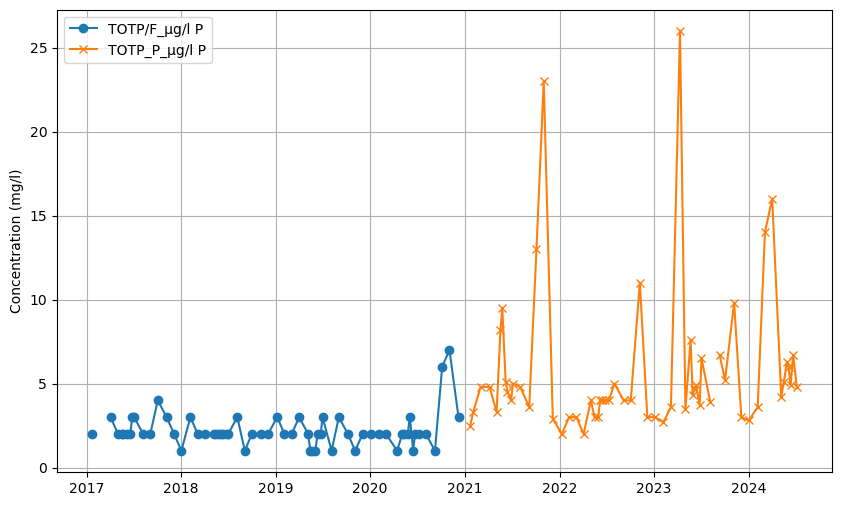

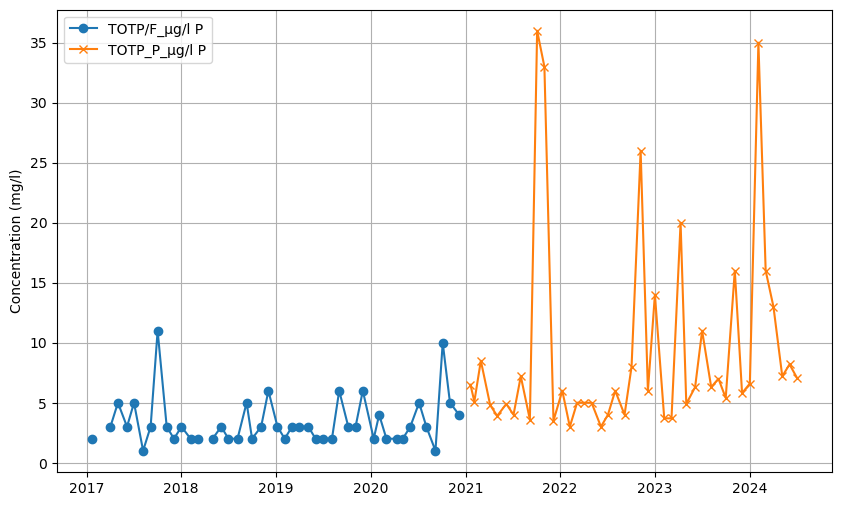

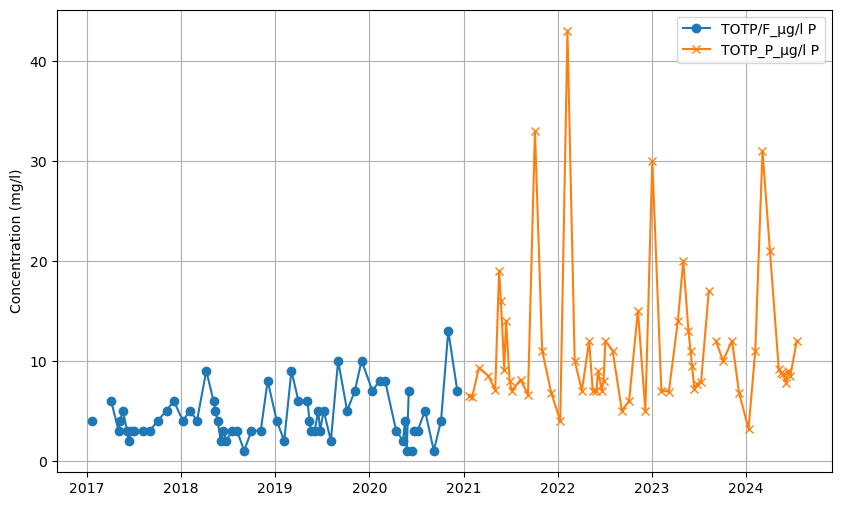

In [8]:
for station in stations:
    station_df = df[df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['TOTP/F_µg/l P'], label='TOTP/F_µg/l P', marker='o')
    plt.plot(station_df['sample_date'], station_df['TOTP_P_µg/l P'], label='TOTP_P_µg/l P', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

### 5. UV-Abs vs Farge

**Note form Leah:** The main reason to  look at UV-Abs is to quality control the CDOM data. Hopefully there is an extremely good correlation with UV-Abs! If not, then one or the other is dodgy... So it's fine if we only have data after 2017. We're not interested in fluxes of UV-Abs to the fjord.

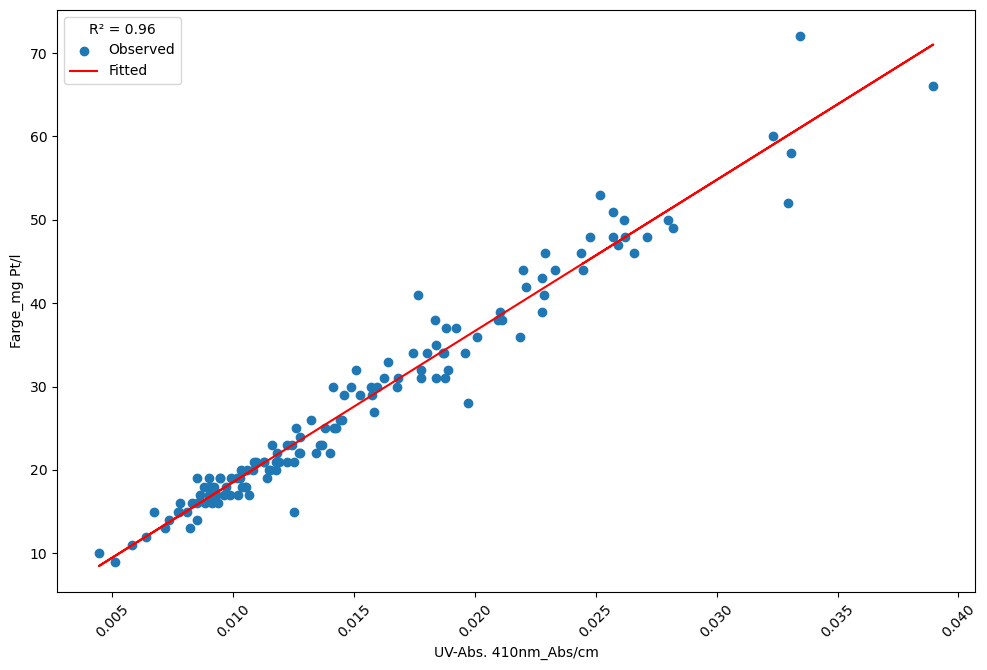

{('Farge_mg Pt/l', 'UV-Abs. 410nm_Abs/cm'): [0.9603174406718495, 1812.692104983612, 0.41315806898831453]}


In [9]:
# Variables of interest
wc_var_1 = 'Farge_mg Pt/l'
wc_var_2 = 'UV-Abs. 410nm_Abs/cm'

# Initialize dictionary to store model coefficients and R-squared values
model_r2_coeffs = {}

fig, ax = plt.subplots(figsize=(10, 7))
df_reg = df[[wc_var_1, wc_var_2]].dropna()
    
if not df.empty:
    X = sm.add_constant(df_reg[wc_var_2])  # independent variable
    y = df_reg[wc_var_1]  # dependent variable
        
    model = sm.OLS(y, X)
    results = model.fit()
        
    m, c = results.params[wc_var_2], results.params['const']
    model_r2_coeffs[(wc_var_1, wc_var_2)] = [results.rsquared, m, c]
        
    ax.scatter(df_reg[wc_var_2], df_reg[wc_var_1], label='Observed')
    ax.plot(df_reg[wc_var_2], results.fittedvalues, color='red', label='Fitted')
    ax.set_xlabel(wc_var_2)
    ax.set_ylabel(wc_var_1)
    r2 = results.rsquared
    ax.legend(title=f'R² = {r2:.2f}')
    ax.tick_params(axis='x', rotation=45) 
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

print(model_r2_coeffs)

In [10]:
df_glo = df[df['station_code'].str.contains('GLO')]
df_glo.head()

,sample_date,station_id,station_code,station_name,DOC_mg/L C,outlier_DOC_mg/L C,Farge_mg Pt/l,outlier_Farge_mg Pt/l,NH4-N_µg/l,outlier_NH4-N_µg/l,...,TOTP/F_µg/l P,outlier_TOTP/F_µg/l P,TOTP_P_µg/l P,outlier_TOTP_P_µg/l P,TSM_mg/l,outlier_TSM_mg/l,UV-Abs. 410nm_Abs/cm,outlier_UV-Abs. 410nm_Abs/cm,DOC/TOC,POC_mg/l
1012,1990-01-10,40356,GLO1,Glomma v/Sarpefossen,3.12,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.5,False,NaN,NaN,0.954128,0.15
1013,1990-02-12,40356,GLO1,Glomma v/Sarpefossen,3.12,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100.8,True,NaN,NaN,0.954128,0.15
1014,1990-03-14,40356,GLO1,Glomma v/Sarpefossen,3.12,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26.8,False,NaN,NaN,0.954128,0.15
1015,1990-04-04,40356,GLO1,Glomma v/Sarpefossen,3.81,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15.3,False,NaN,NaN,0.981959,0.07
1016,1990-04-26,40356,GLO1,Glomma v/Sarpefossen,5.62,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.1,False,NaN,NaN,0.996454,0.02


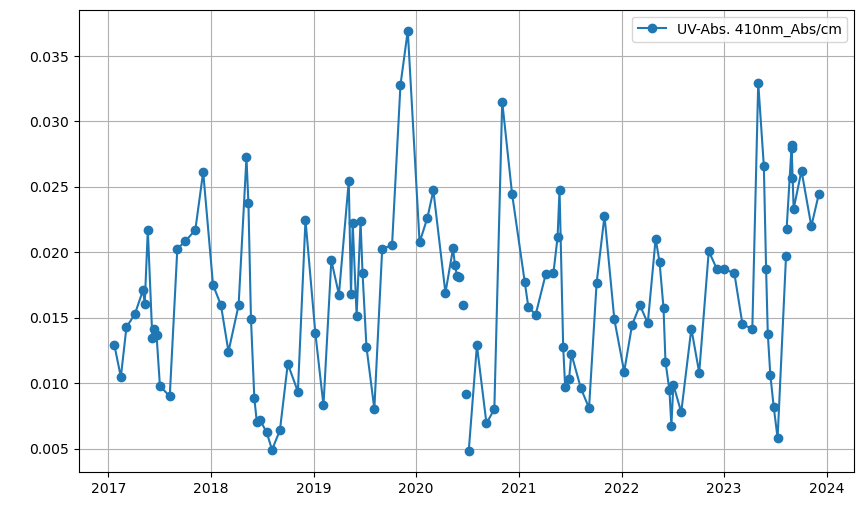

In [11]:
plt.figure(figsize=(10,6))
plt.plot(station_df['sample_date'], station_df['UV-Abs. 410nm_Abs/cm'], label='UV-Abs. 410nm_Abs/cm', marker='o')
    
plt.xlabel(' ')
plt.ylabel(' ')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
sensor_df = pd.read_csv("../../data/river/sensors/daily_glomma_sensor_data_2024-08-28_cleaned_manualy.csv")
sensor_df = sensor_df.drop('Unnamed: 0', axis=1)
sensor_df['Date'] = pd.to_datetime(sensor_df['Date'])
sensor_df.set_index('Date', inplace=True)
sensor_df.head()

,CDOMdigitalFinal (µg/L),PhValue_Avg (-),Temp_water_Avg (degC),CondValue_Avg (µS/cm),Turbidity_Avg (NTU),Salinity_Avg (-)
Date,,,,,,
2023-02-02,76.000,NaN,0.0900,35.350,8.1700,0.019
2023-02-03,75.430,7.5330,0.0595,34.580,8.1200,0.019
2023-02-04,74.765,7.3875,0.0300,33.615,8.8900,0.018
2023-02-05,74.645,7.2770,0.0635,32.585,7.8885,0.017
2023-02-06,73.385,7.2950,0.1325,32.685,6.1120,0.018


In [13]:
df_glo['sample_date'] = pd.to_datetime(df_glo['sample_date'])
df_glo.set_index('sample_date', inplace=True)

merged_df = pd.merge(sensor_df, df_glo, left_index=True, right_index=True, how='inner')
merged_df

/tmp/ipykernel_8817/94154622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glo['sample_date'] = pd.to_datetime(df_glo['sample_date'])


,CDOMdigitalFinal (µg/L),PhValue_Avg (-),Temp_water_Avg (degC),CondValue_Avg (µS/cm),Turbidity_Avg (NTU),Salinity_Avg (-),station_id,station_code,station_name,DOC_mg/L C,...,TOTP/F_µg/l P,outlier_TOTP/F_µg/l P,TOTP_P_µg/l P,outlier_TOTP_P_µg/l P,TSM_mg/l,outlier_TSM_mg/l,UV-Abs. 410nm_Abs/cm,outlier_UV-Abs. 410nm_Abs/cm,DOC/TOC,POC_mg/l
2023-02-06,73.385,7.2950,0.1325,32.685,6.1120,0.0180,40356,GLO1,Glomma v/Sarpefossen,4.2,...,NaN,NaN,7.0,False,3.56,False,0.018394,False,1.000000,0.0
2023-03-07,60.425,7.3010,0.3850,40.065,9.0450,0.0210,40356,GLO1,Glomma v/Sarpefossen,3.6,...,NaN,NaN,6.9,False,5.04,False,0.014486,False,1.000000,0.0
2023-04-11,57.580,7.0975,3.1395,49.215,16.9250,0.0260,40356,GLO1,Glomma v/Sarpefossen,3.9,...,NaN,NaN,14.0,False,9.96,False,0.014138,False,1.000000,0.0
2023-05-02,87.100,6.7215,4.3035,41.890,22.2600,0.0220,40356,GLO1,Glomma v/Sarpefossen,6.2,...,NaN,NaN,20.0,False,19.00,False,0.032936,False,1.000000,0.0
2023-05-22,81.650,6.0940,8.0650,29.050,12.1200,0.0160,40356,GLO1,Glomma v/Sarpefossen,6.0,...,NaN,NaN,13.0,False,4.60,False,0.026580,False,1.000000,0.0
2023-05-30,60.410,6.2595,9.1550,30.755,8.9650,0.0160,40356,GLO1,Glomma v/Sarpefossen,4.1,...,NaN,NaN,11.0,False,11.90,False,0.018744,False,0.953488,0.2
2023-06-05,54.160,6.3840,10.3550,34.245,5.0805,0.0180,40356,GLO1,Glomma v/Sarpefossen,3.7,...,NaN,NaN,9.5,False,5.52,False,0.013788,False,1.000000,0.0
2023-06-14,37.475,6.4595,14.8400,38.800,5.0670,0.0210,40356,GLO1,Glomma v/Sarpefossen,2.8,...,NaN,NaN,7.2,False,4.15,False,0.010650,False,0.933333,0.2
2023-06-26,28.675,6.4945,17.7650,40.335,5.9105,0.0220,40356,GLO1,Glomma v/Sarpefossen,2.5,...,NaN,NaN,7.7,False,4.49,False,0.008192,False,1.000000,0.0
2023-07-10,25.960,6.5365,17.6650,37.625,4.9975,0.0200,40356,GLO1,Glomma v/Sarpefossen,2.2,...,NaN,NaN,7.9,False,3.21,False,0.005808,False,0.956522,0.1


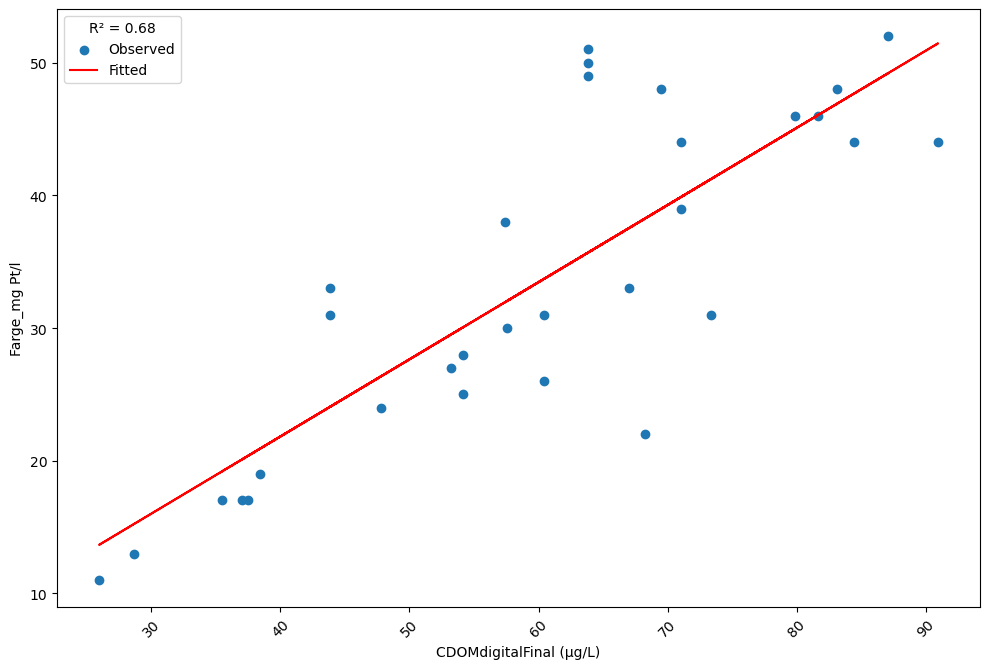

{('Farge_mg Pt/l', 'CDOMdigitalFinal (µg/L)'): [0.6788334170415831, 0.581730528197673, -1.4462518647028801]}


In [14]:
# Variables of interest
wc_var = 'Farge_mg Pt/l' #'UV-Abs. 410nm_Abs/cm'
sensor_var = 'CDOMdigitalFinal (µg/L)'

# Initialize dictionary to store model coefficients and R-squared values
model_r2_coeffs = {}


fig, ax = plt.subplots(figsize=(10, 7))
    
# Filter the DataFrame for the variables of interest and drop missing values
df_reg = merged_df[[wc_var, sensor_var]].dropna()
    
if not df.empty:
    X = sm.add_constant(df_reg[sensor_var])  # independent variable
    y = df_reg[wc_var]  # dependent variable
        
    model = sm.OLS(y, X)
    results = model.fit()
        
    m, c = results.params[sensor_var], results.params['const']
    model_r2_coeffs[(wc_var, sensor_var)] = [results.rsquared, m, c]
        
    ax.scatter(df_reg[sensor_var], df_reg[wc_var], label='Observed')
    ax.plot(df_reg[sensor_var], results.fittedvalues, color='red', label='Fitted')
    ax.set_xlabel(sensor_var)
    ax.set_ylabel(wc_var)
    r2 = results.rsquared
    ax.legend(title=f'R² = {r2:.2f}')
    ax.tick_params(axis='x', rotation=45) 
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

print(model_r2_coeffs)

**Leah:** The UV-Abs vs CDOM regression is ok, but actually not as nice as I would have hoped. I wonder whether that's a problem with the CDOM or the UVAbs, or whether it's just that CDOM is measuring a different part of the spectrum. Quick question: does farge vs CDOM look any better? How about farge vs UV-Abs? Just trying to figure out which of these variables are untrustworthy...

### 6. NH4 vs NO3
If NH4 values are too small compared to NO3 then we can summarize to DIN. 

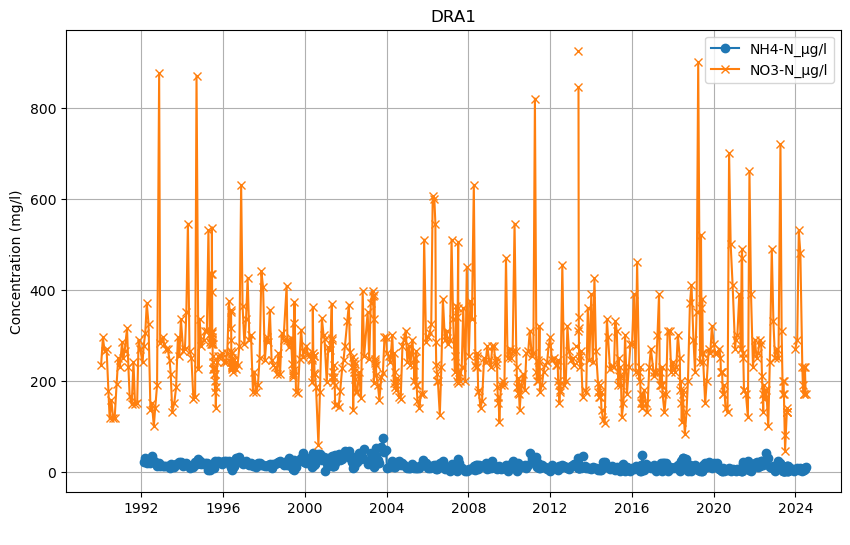

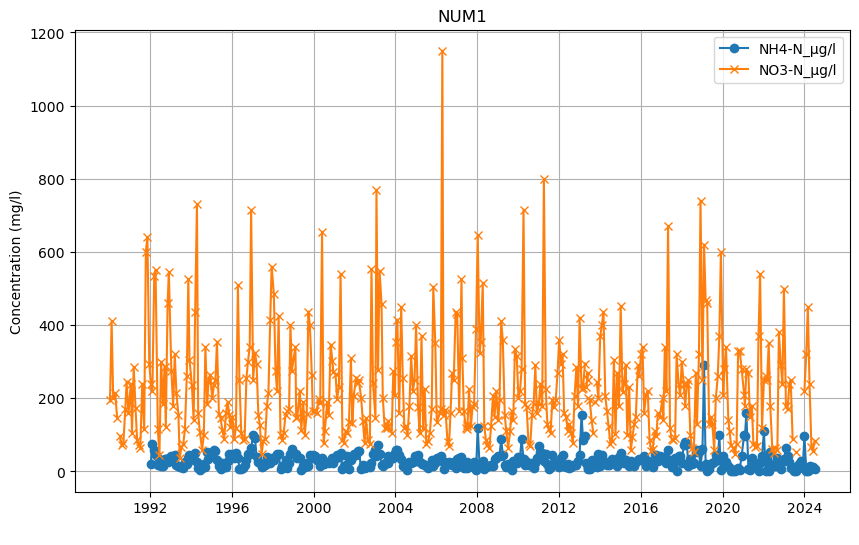

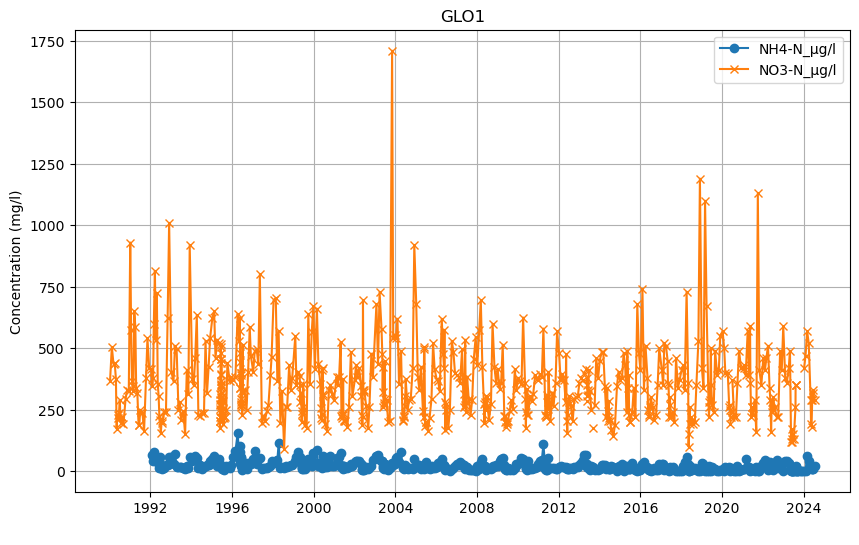

In [15]:
for station in stations:
    station_df = df[df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['NH4-N_µg/l'], label='NH4-N_µg/l', marker='o')
    plt.plot(station_df['sample_date'], station_df['NO3-N_µg/l'], label='NO3-N_µg/l', marker='x')
    
    plt.xlabel(' ')
    plt.title(station)
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

Areti thinks that NO3 values are quite higher compared to NH4, particularly in Dram and Glomma. There are a few exeptions for Num, where NH4 levels are close to NO3, although in general NH4<<NO3, soo we could just summarize those to DIN for simplification.

### 7. Get the parameters of interest for estimating daily chem
After looking into the data we ended up with the following key chemical species: TSM, TOC, DIN, Farge, PO4-P, SiO2, TOTN, TOTP - filtered, TOTP - unfiltered.

In [16]:
df['DIN_mg/l'] = df['NH4-N_µg/l'] + df['NO3-N_µg/l']  
df

,sample_date,station_id,station_code,station_name,DOC_mg/L C,outlier_DOC_mg/L C,Farge_mg Pt/l,outlier_Farge_mg Pt/l,NH4-N_µg/l,outlier_NH4-N_µg/l,...,outlier_TOTP/F_µg/l P,TOTP_P_µg/l P,outlier_TOTP_P_µg/l P,TSM_mg/l,outlier_TSM_mg/l,UV-Abs. 410nm_Abs/cm,outlier_UV-Abs. 410nm_Abs/cm,DOC/TOC,POC_mg/l,DIN_mg/l
0,1990-01-11,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.80,False,NaN,NaN,NaN,NaN,NaN
1,1990-02-12,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.00,False,NaN,NaN,NaN,NaN,NaN
2,1990-03-13,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.40,False,NaN,NaN,NaN,NaN,NaN
3,1990-04-18,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.30,False,NaN,NaN,NaN,NaN,NaN
4,1990-05-21,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.70,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,2024-05-22,40356,GLO1,Glomma v/Sarpefossen,3.8,False,27.0,False,10.0,False,...,NaN,8.7,False,7.29,False,NaN,NaN,1.000000,0.0,190.0
1625,2024-06-03,40356,GLO1,Glomma v/Sarpefossen,3.0,False,19.0,False,8.0,False,...,NaN,7.8,False,4.42,False,NaN,NaN,1.000000,0.0,298.0
1626,2024-06-12,40356,GLO1,Glomma v/Sarpefossen,3.0,False,17.0,False,13.0,False,...,NaN,9.0,False,1.00,False,NaN,NaN,1.000000,0.0,343.0
1627,2024-06-20,40356,GLO1,Glomma v/Sarpefossen,3.8,False,24.0,False,9.0,False,...,NaN,8.5,False,4.63,False,NaN,NaN,1.027027,-0.1,329.0


In [17]:
selected_columns = ['sample_date', 'station_id', 'station_code', 'station_name',
                    'Farge_mg Pt/l', 'DIN_mg/l', 'PO4-P_µg/l', 'SiO2_mg/l', 'TOC_mg/l',
                    'TOTN_µg/l', 'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'TSM_mg/l']
df_selected = df[selected_columns]
df_selected

,sample_date,station_id,station_code,station_name,Farge_mg Pt/l,DIN_mg/l,PO4-P_µg/l,SiO2_mg/l,TOC_mg/l,TOTN_µg/l,TOTP/F_µg/l P,TOTP_P_µg/l P,TSM_mg/l
0,1990-01-11,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,0.5,NaN,NaN,350.0,NaN,NaN,0.80
1,1990-02-12,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,2.0,NaN,NaN,419.0,NaN,NaN,2.00
2,1990-03-13,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,1.5,NaN,NaN,405.0,NaN,NaN,1.40
3,1990-04-18,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,1.5,NaN,NaN,399.0,NaN,NaN,1.30
4,1990-05-21,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,0.5,NaN,NaN,317.0,NaN,NaN,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,2024-05-22,40356,GLO1,Glomma v/Sarpefossen,27.0,190.0,6.0,3.28,3.8,320.0,NaN,8.7,7.29
1625,2024-06-03,40356,GLO1,Glomma v/Sarpefossen,19.0,298.0,5.0,3.15,3.0,420.0,NaN,7.8,4.42
1626,2024-06-12,40356,GLO1,Glomma v/Sarpefossen,17.0,343.0,4.0,3.18,3.0,480.0,NaN,9.0,1.00
1627,2024-06-20,40356,GLO1,Glomma v/Sarpefossen,24.0,329.0,4.0,3.23,3.7,470.0,NaN,8.5,4.63


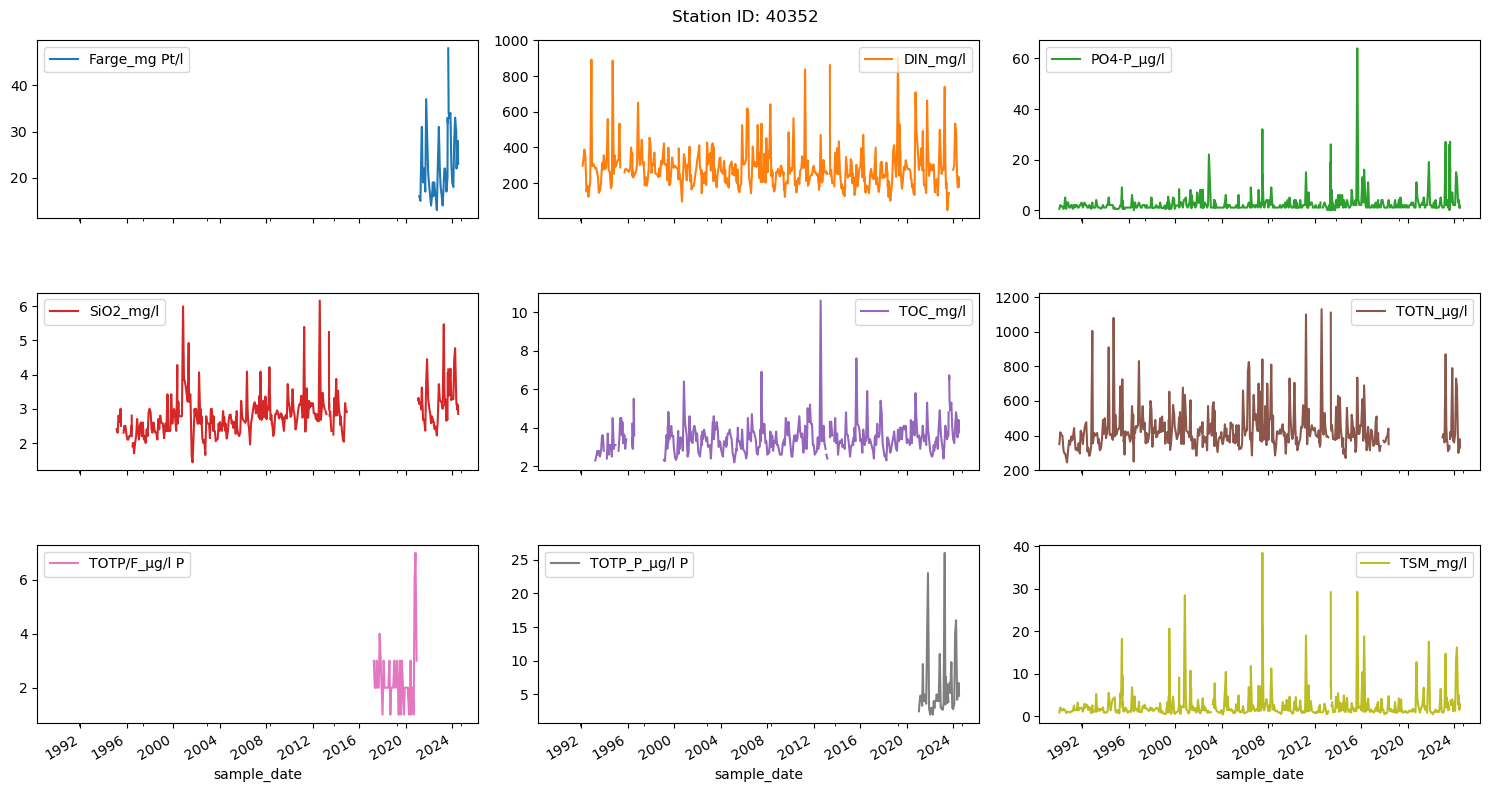

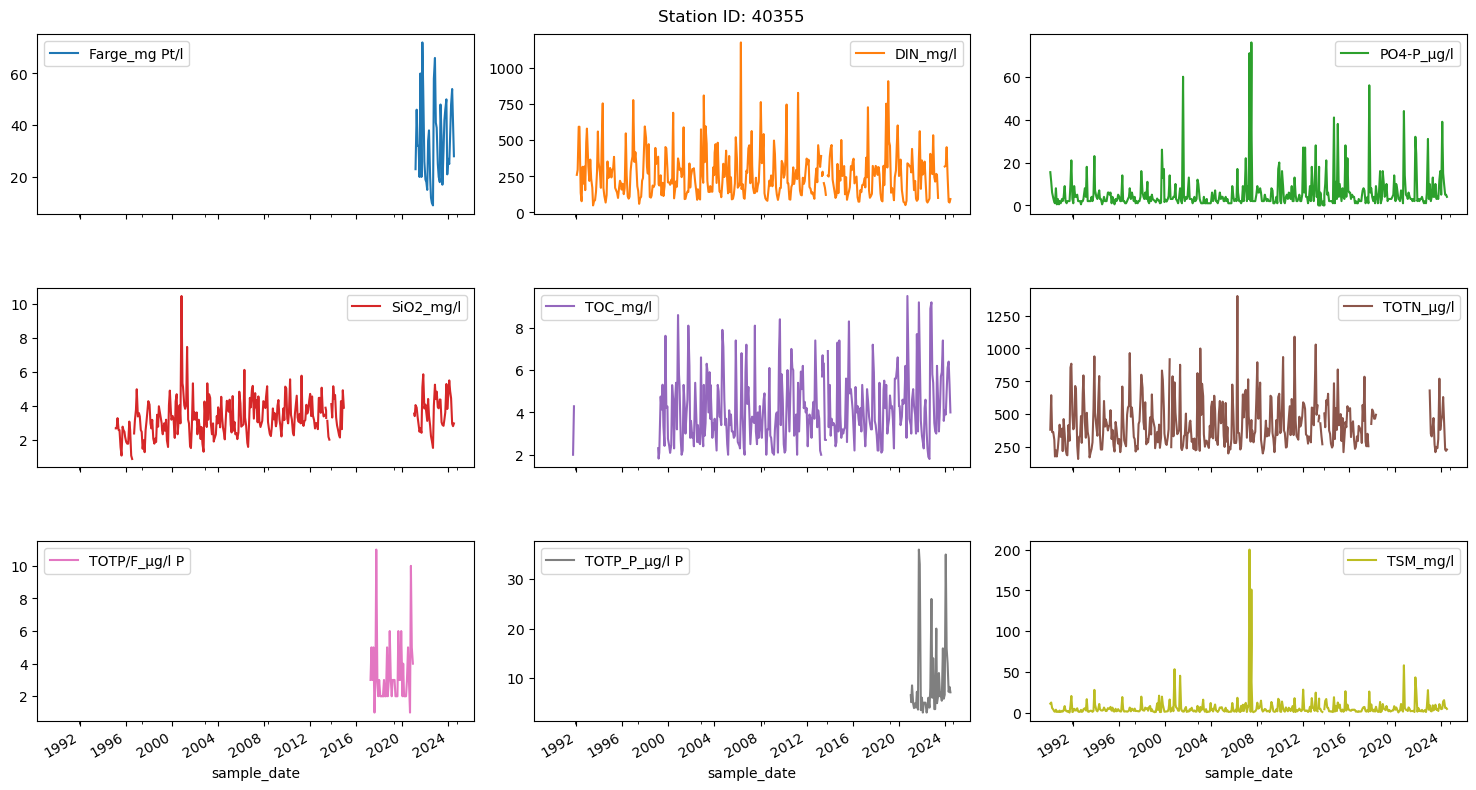

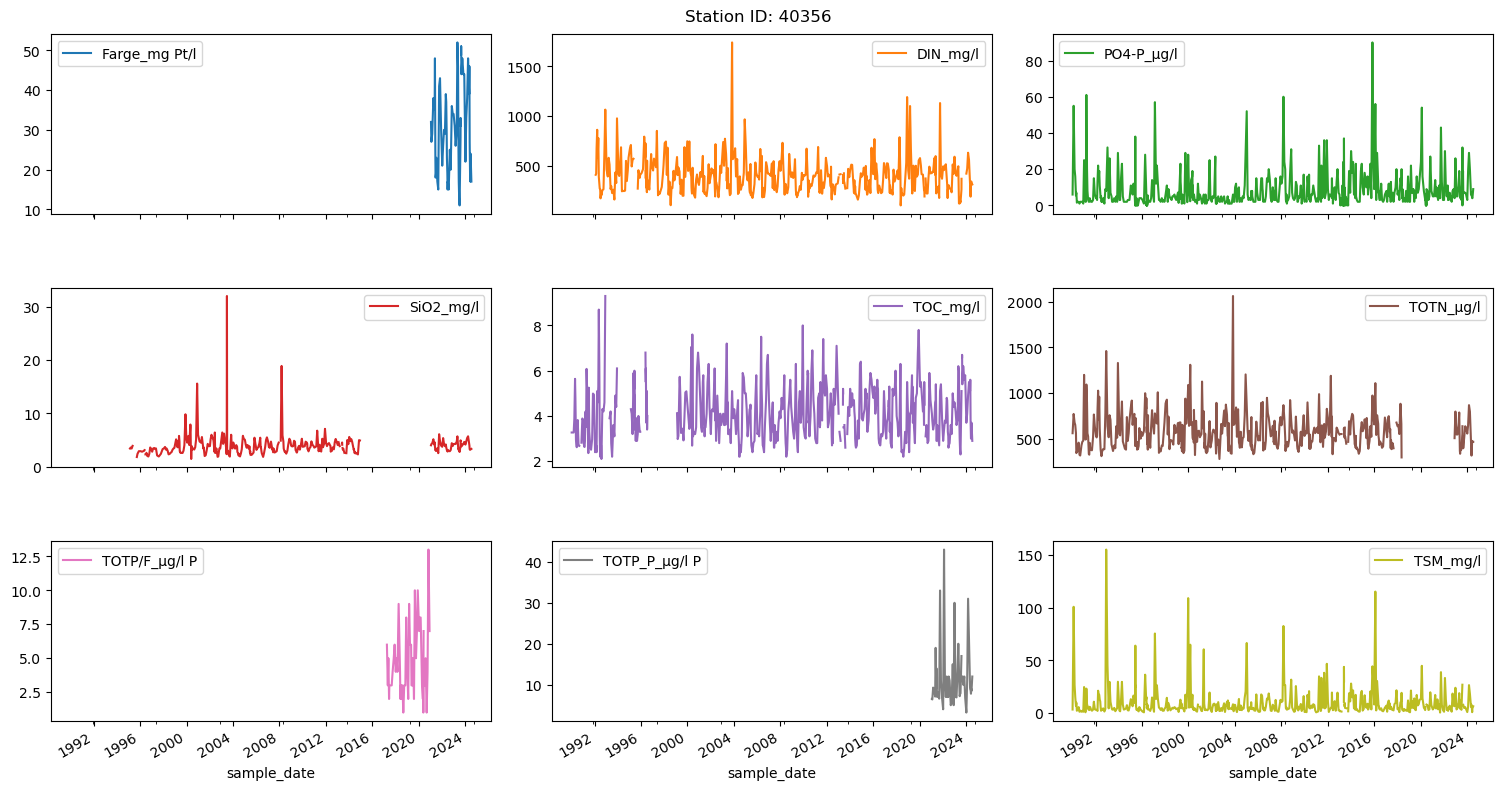

In [18]:
# Quick plots
stations = df_selected['station_id'].unique()

for station in stations:
    station_data = df_selected[df_selected['station_id'] == station].drop(columns=['station_id'])
    station_data.plot(x='sample_date', subplots=True, layout=(4, 3), figsize=(15, 10), title=f'Station ID: {station}')
    plt.tight_layout()
    plt.show()

In [19]:
# Save as csv
df_selected.to_csv('../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_key_wc_species_cleaned.csv', index=False)